In [ ]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib import rc
import time
plt.rcParams["font.size"] = 15
%matplotlib inline
print("Version of pytorch is {}".format(torch.__version__))

psi = 1.0
theta = 1.0

Version of pytorch is 2.2.1+cu121


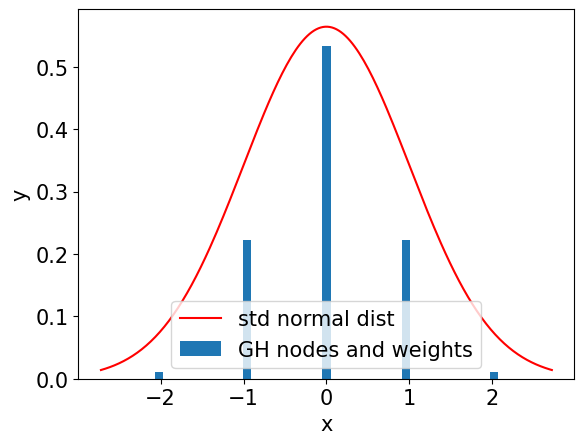

sum(w_int) =  1.0000001


In [ ]:
n_int = 5
x_int_norm, w_int  = np.polynomial.hermite.hermgauss(n_int)
w_int = w_int / np.sqrt(np.pi)
x_int = x_int_norm * math.sqrt(2)
x_int_norm = torch.tensor(x_int_norm, dtype=torch.float32)
x_int_norm_plot = x_int_norm.detach().numpy()
w_int = torch.tensor(w_int, dtype=torch.float32)
w_int_plot = w_int.detach().numpy()
# for plw_intotting the normal distribution
x_plot_norm = np.linspace(np.min(x_int_norm_plot) - 0.7, np.max(x_int_norm_plot) + 0.7, 200)
y_plot_norm = np.exp(- 0.5 * x_plot_norm ** 2) / np.sqrt(np.pi)

plt.bar(x_int_norm_plot, w_int_plot, width = 0.1, label = "GH nodes and weights")
plt.plot(x_plot_norm, y_plot_norm, color = "r", label = "std normal dist")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

# we should make sure the weights some to 1
print("sum(w_int) = ", np.sum(w_int_plot))

In [ ]:
alpha = 0.36  # Capital share in the Cobb-Douglas production function
beta = 0.99  # Discount factor
delta = 0.1 # depreciation of capital
sigma_tfp = 0.04 # std. dev. for tfp process innvoations
rho_tfp = 0.9 # persistence of tfp process
x_int = x_int_norm * sigma_tfp # adjust the integration nodes

In [ ]:
num_input = 2
num_hidden1 = 50
num_hidden2 = 50
num_output = 1
layers_dim = [num_input,num_hidden1, num_hidden2, num_output]
print("Dimensions of each layer are {}".format(layers_dim))

Dimensions of each layer are [2, 50, 50, 1]


In [ ]:
class DQN(nn.Module):
  def __init__(self, num_input,num_hidden1,num_hidden2,num_output):
    super(DQN,self).__init__()
    self.layer1 = nn.Linear(num_input,num_hidden1)
    self.layer2 = nn.Linear(num_hidden1,num_hidden2)
    self.layer3 = nn.Linear(num_hidden2, num_output)

  def forward(self,x):
    x = F.relu(self.layer1(x))
    x = F.relu(self.layer2(x))
    x = torch.sigmoid(self.layer3(x))
    return x

model = DQN(num_input,num_hidden1,num_hidden2,num_output)
print(model)

DQN(
  (layer1): Linear(in_features=2, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=1, bias=True)
)


In [60]:
def get_singleinside(X_tplus1, model):
    n_data = X_tplus1.shape[0]  # 状态的数量在轴0上
    dim_state = X_tplus1.shape[1]  # 状态的维度在轴1上

    # 读取状态
    Z_tplus1 = X_tplus1[:, 0]  # 直接使用索引来提取Z_tplus1
    K_tplus1 = X_tplus1[:, 1]  # 直接使用索引来提取K_tplus1

    # 计算输出
    Y_tplus1 = Z_tplus1 * K_tplus1 ** alpha

    # 计算回报
    r_tplus1 = alpha * Z_tplus1 * K_tplus1 ** (alpha - 1.)

    # 使用模型预测储蓄率
    s_tplus1 = model(X_tplus1)

    # 计算消费
    C_tplus1 = Y_tplus1 - Y_tplus1 * s_tplus1

    # 计算期望中的项
    ret = (1. / C_tplus1) * (1. - delta + r_tplus1)

    return ret

X_tplus1 = torch.tensor([[1., 1.], [2., 2.], [2., 1.3]])
print("ret = ", get_singleinside(X_tplus1, model))

ret =  tensor([[2.6341, 1.1093, 1.4349],
        [2.6435, 1.1133, 1.4400],
        [2.7063, 1.1397, 1.4742]], grad_fn=<MulBackward0>)


In [62]:
def compute_cost_tuple(X, model):
    n_data = X.shape[0] # number of states is on the axis 0
    dim_state = X.shape[1] # dimensionality of the state is on axis 1

    # read out the state
    Z_t = X[:, 0:1]
    K_t = X[:, 1:2]

    # compute output today
    Y_t = Z_t * K_t ** alpha

    # compute return (not really needed)
    r_t = alpha * Z_t * K_t ** (alpha - 1.)

    # use the neural network to predict the savings rate
    s_t = model(X)

    # get the implied capital in the next period
    K_tplus1 = (1. - delta) * K_t + Y_t * s_t

    # get consumption
    C_t = Y_t - Y_t * s_t

    # now we have to compute the expectation
    expectation = torch.zeros((n_data, dim_state))

    # we loop over the integration nodes
    for i in range(n_int):
        # integration weight
        weight_i = w_int[i]

        # innovation to the AR(1)
        innovation_i = x_int[i]

        # construct exogenous shock at t+1
        Z_tplus1 = torch.exp(rho_tfp * torch.log(Z_t) + innovation_i)

        # construct state at t+1
        X_tplus1 = torch.cat([Z_tplus1, K_tplus1], dim=1)

        # compute term inside the expeectation
        inside_i = get_singleinside(X_tplus1, model)

        # add term to the expectaion with the appropriate weight
        expectation += weight_i * inside_i

    # now we have all terms to construct the relative Euler error

    # Define the relative Euler error
    errREE = 1. - 1. / (C_t * beta * expectation)

    # compute the cost, i.e. the mean square error in the equilibrium conditions
    cost = torch.mean(errREE ** 2)

    # we return some more things for plotting
    LHS = 1. / C_t # LHS of Ee
    RHS = beta * expectation # RHS of Ee

    return cost, errREE, C_t, K_tplus1, r_t, LHS, RHS


def compute_cost(X, model):
    n_data = X.shape[0] # number of states is on the axis 0
    dim_state = X.shape[1] # dimensionality of the state is on axis 1

    # read out the state
    Z_t = X[:, 0:1]
    K_t = X[:, 1:2]

    # compute output today
    Y_t = Z_t * K_t ** alpha

    # compute return (not really needed)
    r_t = alpha * Z_t * K_t ** (alpha - 1.)

    # use the neural network to predict the savings rate
    s_t = model(X)

    # get the implied capital in the next period
    K_tplus1 = (1. - delta) * K_t + Y_t * s_t

    # get consumption
    C_t = Y_t - Y_t * s_t

    # now we have to compute the expectation
    expectation = torch.zeros((n_data, dim_state))

    # we loop over the integration nodes
    for i in range(n_int):
        # integration weight
        weight_i = w_int[i]

        # innovation to the AR(1)
        innovation_i = x_int[i]

        # construct exogenous shock at t+1
        Z_tplus1 = torch.exp(rho_tfp * torch.log(Z_t) + innovation_i)

        # construct state at t+1
        X_tplus1 = torch.cat([Z_tplus1, K_tplus1], dim=1)

        # compute term inside the expeectation
        inside_i = get_singleinside(X_tplus1, model)

        # add term to the expectaion with the appropriate weight
        expectation += weight_i * inside_i

    # now we have all terms to construct the relative Euler error

    # Define the relative Euler error
    errREE = 1. - 1. / (C_t * beta * expectation)

    # compute the cost, i.e. the mean square error in the equilibrium conditions
    cost = torch.mean(errREE ** 2)

    # we return some more things for plotting
    LHS = 1. / C_t # LHS of Ee
    RHS = beta * expectation # RHS of Ee

    return cost

def compute_cost_tuple1(X, model):
    n_data = X.shape[0]  # 状态的数量在轴0上
    dim_state = X.shape[1]  # 状态的维度在轴1上

    # 读取状态
    Z_t = X[:, 0:1]
    K_t = X[:, 1:2]

    # 计算输出
    Y_t = Z_t * K_t ** alpha

    # 计算回报（实际上并不需要）
    r_t = alpha * Z_t * K_t ** (alpha - 1.)

    # 使用神经网络预测储蓄率
    s_t = model(X)

    # 获取下一期的隐含资本
    K_tplus1 = (1. - delta) * K_t + Y_t * s_t

    # 获取消费
    C_t = Y_t - Y_t * s_t

    # 预计算重复计算
    Y_t_s_t = Y_t * s_t
    one_minus_beta = 1. - beta
    one_minus_delta_plus_r_t = (1. - delta) + r_t

    # 扩展Z_t和K_tplus1的维度以进行广播
    Z_t_expanded = Z_t[:, None, :].expand(n_data, n_int, 1)
    K_tplus1_expanded = K_tplus1[:, None, :].expand(n_data, n_int, 1)

    # 计算所有积分节点处的t+1时的外生冲击
    innovation_expanded = x_int[None, :, None].expand(n_data, n_int, 1)
    Z_tplus1_all = torch.exp(rho_tfp * torch.log(Z_t_expanded) + innovation_expanded)

    # 为所有积分节点构造t+1时的状态
    X_tplus1_all = torch.cat([Z_tplus1_all, K_tplus1_expanded], dim=2)

    # 计算所有积分节点处的期望中的项
    inside_all = get_singleinside(X_tplus1_all.view(-1, dim_state), model)
    inside_all = inside_all.view(n_data, n_int, -1)

    # 计算期望
    expectation = torch.sum(w_int[None, :, None] * inside_all, dim=1)

    # 定义相对欧拉误差
    errREE = 1. - one_minus_beta / (C_t * expectation)

    # 计算成本，即在均衡条件下的均方误差
    cost = torch.mean(errREE ** 2)

    # 我们返回一些额外的信息以便绘图
    LHS = one_minus_beta / C_t  # Ee的左侧
    RHS = beta * expectation  # Ee的右侧

    return cost, errREE, C_t, K_tplus1, r_t, LHS, RHS

X = torch.tensor([[0.5, 1.], [0.9, 2.], [1.1, 3.]])

#print("cost = ", compute_cost_tuple(X, model)[0])
print("cost = ", compute_cost_tuple1(X, model)[0])

cost =  tensor(0.9749, grad_fn=<MeanBackward0>)


In [58]:
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
num_episodes = 20001
n_data_per_epi = 128
z_lb = 0.7
z_ub = 1.3
k_lb = 0.9
k_ub = 12.0

In [ ]:
# Define the simulate_single_step function
def simulate_single_step(X_t, eps_tplus1, model):
    # Read out the state
    Z_t = X_t[:, 0:1]
    K_t = X_t[:, 1:2]

    # Get Z_tplus1
    Z_tplus1 = torch.exp(rho_tfp * torch.log(Z_t) + sigma_tfp * eps_tplus1)

    # Compute output today
    Y_t = Z_t * K_t ** alpha

    # Use the neural network to predict the savings rate
    s_t = model(X_t)

    # Get the implied capital in the next period
    K_tplus1 = (1. - delta) * K_t + Y_t * s_t

    # Construct the next step
    X_tplus1 = torch.cat([Z_tplus1, K_tplus1], dim=1)

    return X_tplus1

# Define the sim_periods function
def sim_periods(X_start, model, num_periods):
    n_tracks, dim_state = X_start.shape

    # Create an empty array to store the states
    X_simulation = torch.empty((num_periods, n_tracks, dim_state))

    # Draw random innovation
    eps = torch.randn((num_periods, n_tracks), dtype=torch.float32)

    # Set starting state
    X_simulation[0, :, :] = X_start

    X_old = X_start

    # Simulate the periods
    for t in range(1, num_periods):
        eps_use = eps[t, :, None]  # None ensures the shape is n_tracks x 1

        X_new = simulate_single_step(X_old, eps_use, model)

        X_simulation[t, :, :] = X_new

        X_old = X_new

    return X_simulation

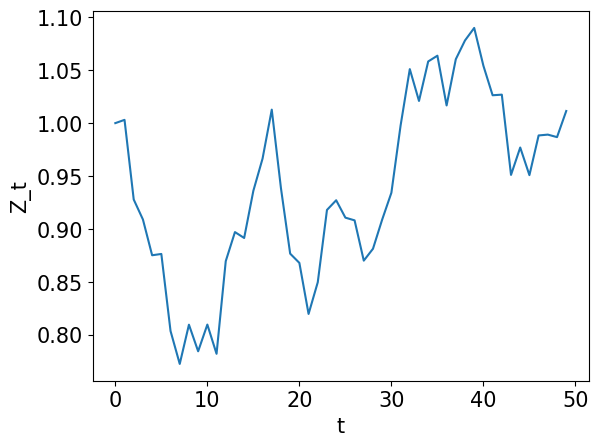

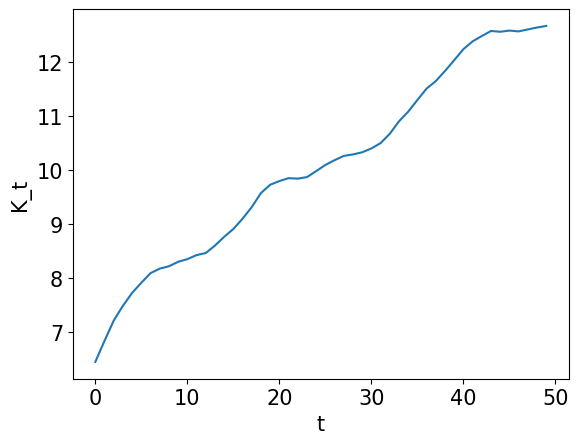

In [ ]:
X_start = np.array([[0.5 * (z_ub + z_lb), 0.5 * (k_ub + k_lb)]], dtype = np.float32)
X_start = torch.tensor(X_start,dtype=torch.float32)
num_periods = 50
X_simulation = sim_periods(X_start, model, num_periods)
X_simulation = X_simulation.detach().numpy()
plt.plot(X_simulation[:, 0, 0])
plt.xlabel("t")
plt.ylabel("Z_t")
plt.show()

plt.plot(X_simulation[:, 0, 1])
plt.xlabel("t")
plt.ylabel("K_t")
plt.show()

In [ ]:
def get_training_data(z_lb, z_ub, k_lb, k_ub, n_data):
    Z = torch.rand(n_data, 1, dtype=torch.float32) * (z_ub - z_lb) + z_lb
    K = torch.rand(n_data, 1, dtype=torch.float32) * (k_ub - k_lb) + k_lb
    X = torch.cat([Z, K], dim=1)
    return X
def get_training_data_simulation(X_start, model, n_periods):
    n_tracks, n_dim = X_start.shape

    X_simulation = sim_periods(X_start, model, n_periods)

    X_end = X_simulation[-1, :, :].to(torch.float32)

    X_training = X_simulation.view(n_tracks * n_periods, n_dim).to(torch.float32)

    return X_training, X_end

In [ ]:
class Policy(nn.Module):
  def __init__(self, num_input,num_hidden1,num_hidden2,num_output):
    super(Policy,self).__init__()
    self.layer1 = nn.Linear(num_input,num_hidden1)
    self.layer2 = nn.Linear(num_hidden1,num_hidden2)
    self.layer3 = nn.Linear(num_hidden2, num_output)

  def forward(self,x):
    x = F.relu(self.layer1(x))
    x = F.relu(self.layer2(x))
    x = torch.sigmoid(self.layer3(x))
    return x

model1 = Policy(num_input,num_hidden1,num_hidden2,num_output)
model2 = Policy(num_input,num_hidden1,num_hidden2,num_output)
print(model1)

n_tracks = 50
n_periods = 3
print("n_tracks = ", n_tracks)
print("n_periods = ", n_periods)

# start from a random state
X_start = get_training_data(z_lb, z_ub, k_lb, k_ub, n_tracks)
print("X_start.shape = ", X_start.shape)

print("With every simulation we get", n_tracks * n_periods, "new states")

X_training, X_end = get_training_data_simulation(X_start, model2, n_periods)
print("X_training.shape = ", X_training.shape)
print("X_end.shape = ", X_end.shape)

learning_rate = 0.0001
print("learning_rate = ", learning_rate)

print(compute_cost(X_start, model1))



Policy(
  (layer1): Linear(in_features=2, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=1, bias=True)
)
n_tracks =  50
n_periods =  3
X_start.shape =  torch.Size([50, 2])
With every simulation we get 150 new states
X_training.shape =  torch.Size([150, 2])
X_end.shape =  torch.Size([50, 2])
learning_rate =  0.0001
tensor(0.0010, grad_fn=<MeanBackward0>)


n_tracks =  50
n_periods =  3
time =  1.953232765197754
#=================================================================
episode = 0, loss [log10] = -0.008990355767309666


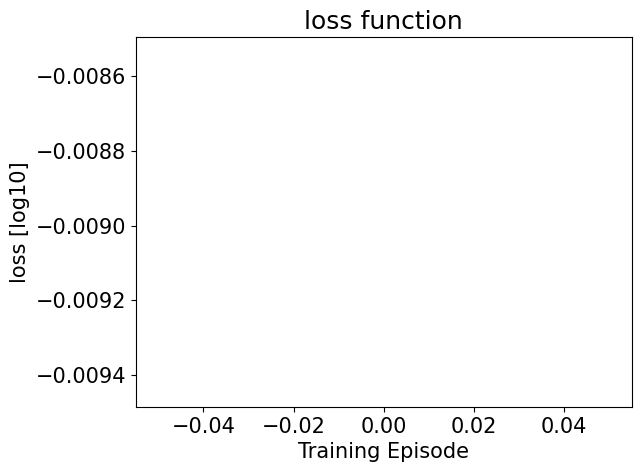

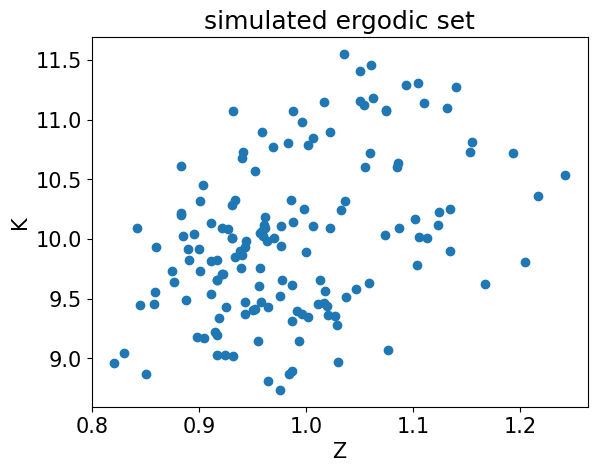

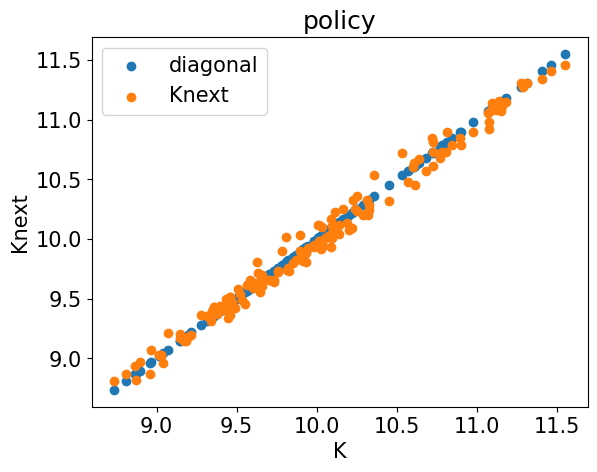

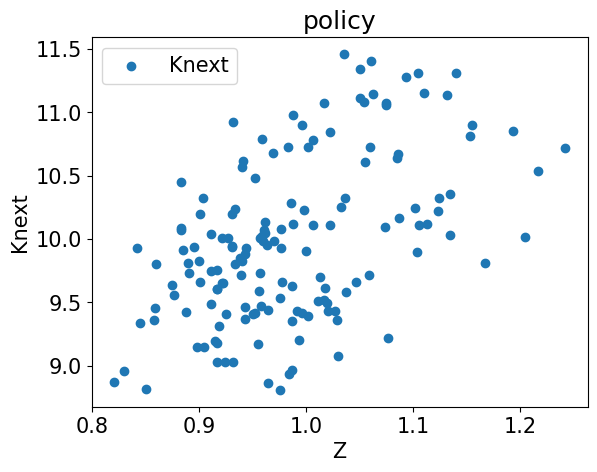

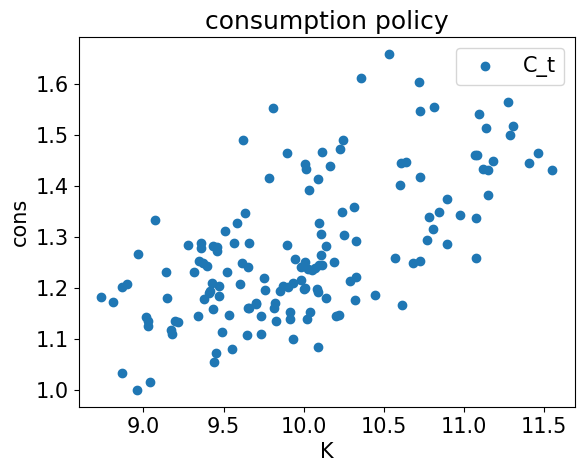

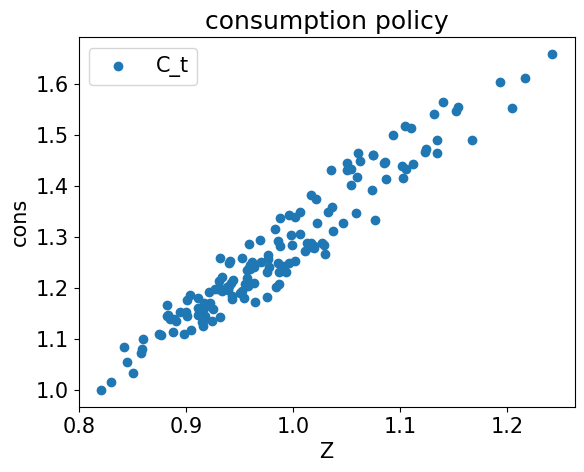

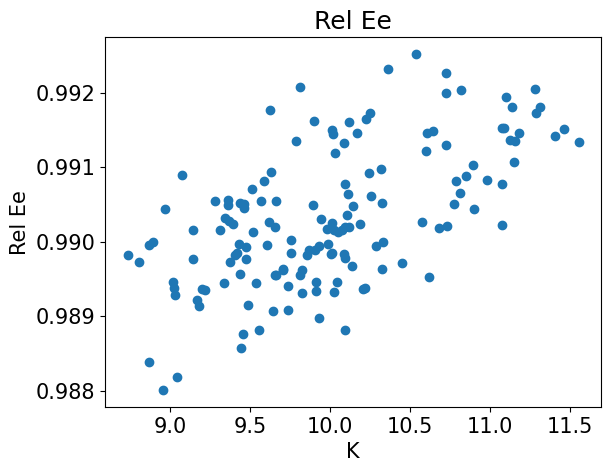

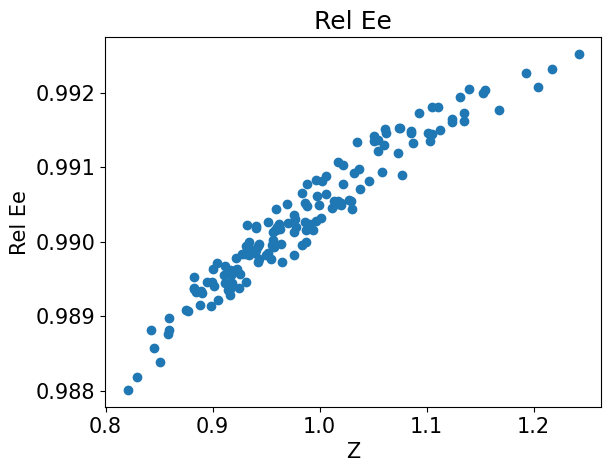

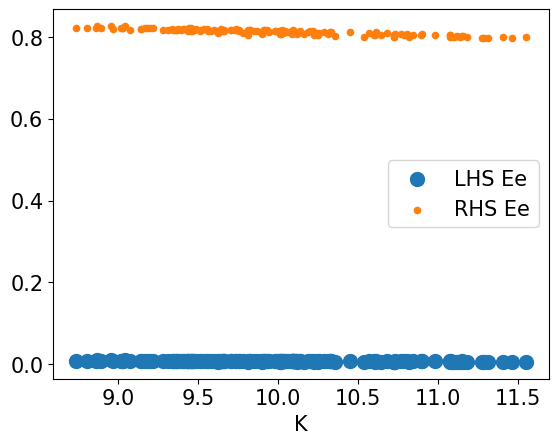

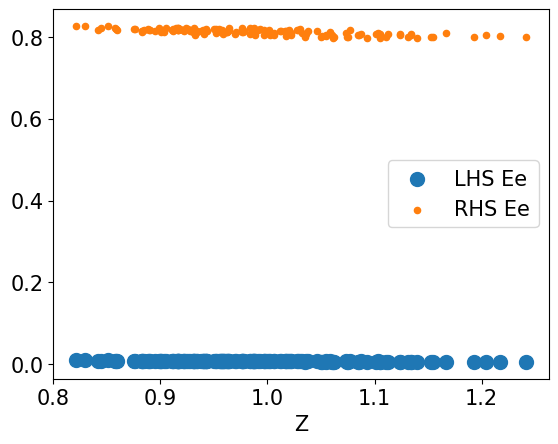

time =  1.916773796081543
#=================================================================
episode = 1, loss [log10] = -0.008992892690002918
time =  1.9066877365112305
#=================================================================
episode = 2, loss [log10] = -0.008984541520476341
time =  2.0022411346435547
#=================================================================
episode = 3, loss [log10] = -0.008980894461274147
time =  2.661142587661743
#=================================================================
episode = 4, loss [log10] = -0.008969319984316826
time =  1.905574083328247
#=================================================================
episode = 5, loss [log10] = -0.008967549540102482
time =  1.901353120803833
#=================================================================
episode = 6, loss [log10] = -0.008970244787633419
time =  1.893453598022461
#=================================================================
episode = 7, loss [log10] = -0.0089739970862865

In [ ]:
train_loss = []

num_episodes = 20001

# initialize X_start
X_start = X_end
print("n_tracks = ", X_start.shape[0])
print("n_periods = ", n_periods)

train_loss = []
num_episodes = 10001
X_start = X_end
for ep in range(num_episodes):
    start_time = time.time()
    X, X_end = get_training_data_simulation(X_start, model2, n_periods)
    X_start = X_end

    loss = compute_cost_tuple1(X, model2)[0]

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    end_time = time.time()
    print("time = ", end_time - start_time)

    train_loss.append(loss.item())


    loss_log10 = torch.log10(loss).item()
    print("#=================================================================")
    print("episode = {}, loss [log10] = {}".format(ep, loss_log10))

    if ep % int(0.2 * num_episodes) == 0 or ep == num_episodes - 1:
      cost, errREE, C_t, K_tplus1, r_t, LHS, RHS = compute_cost_tuple1(X, model)
      cost = cost.detach().numpy()
      errREE = errREE.detach().numpy()
      C_t = C_t.detach().numpy()
      K_tplus1 = K_tplus1.detach().numpy()
      r_t = r_t.detach().numpy()
      LHS = LHS.detach().numpy()
      RHS = RHS.detach().numpy()

    if ep % int(0.2 * num_episodes) == 0 or ep == num_episodes - 1:
        cost, errREE, C_t, K_tplus1, r_t, LHS, RHS = compute_cost_tuple1(X, model2)

        plt.title("loss function")
        plt.plot(loss_log10)
        plt.xlabel("Training Episode")
        plt.ylabel("loss [log10]")
        plt.show()
        plt.close()

        plt.title("simulated ergodic set")
        plt.scatter(X[:, 0].detach().numpy(), X[:, 1].detach().numpy())
        plt.xlabel("Z")
        plt.ylabel("K")
        plt.show()
        plt.close()


        plt.title("policy")
        plt.xlabel("K")
        plt.ylabel("Knext")
        plt.scatter(X[:, 1].detach().numpy(), X[:, 1].detach().numpy(), label = "diagonal")
        plt.scatter(X[:, 1].detach().numpy(), K_tplus1[:, 0].detach().numpy(), label = "Knext")
        plt.legend()
        plt.show()
        plt.close()

        plt.title("policy")
        plt.xlabel("Z")
        plt.ylabel("Knext")
        plt.scatter(X[:, 0].detach().numpy(), K_tplus1[:, 0].detach().numpy(), label = "Knext")
        plt.legend()
        plt.show()
        plt.close()

        plt.title("consumption policy")
        plt.xlabel("K")
        plt.ylabel("cons")
        plt.scatter(X[:, 1].detach().numpy(), C_t[:, 0].detach().numpy(), label="C_t")
        plt.legend()
        plt.show()
        plt.close()

        plt.title("consumption policy")
        plt.xlabel("Z")
        plt.ylabel("cons")
        plt.scatter(X[:, 0].detach().numpy(), C_t[:, 0].detach().numpy(), label="C_t")
        plt.legend()
        plt.show()
        plt.close()

        plt.title("Rel Ee")
        plt.xlabel("K")
        plt.ylabel("Rel Ee")
        plt.scatter(X[:, 1].detach().numpy(), errREE[:, 0].detach().numpy(), label="REE")
        plt.show()
        plt.close()

        plt.title("Rel Ee")
        plt.xlabel("Z")
        plt.ylabel("Rel Ee")
        plt.scatter(X[:, 0].detach().numpy(), errREE[:, 0].detach().numpy(), label="REE")
        plt.show()
        plt.close()

        plt.xlabel("K")
        plt.scatter(X[:, 1].detach().numpy(), LHS[:, 0].detach().numpy(), s = 100, label="LHS Ee")
        plt.scatter(X[:, 1].detach().numpy(), RHS[:, 0].detach().numpy(), s = 20, label="RHS Ee")
        plt.legend()
        plt.show()
        plt.close()

        plt.xlabel("Z")
        plt.scatter(X[:, 0].detach().numpy(), LHS[:, 0].detach().numpy(), s = 100, label="LHS Ee")
        plt.scatter(X[:, 0].detach().numpy(), RHS[:, 0].detach().numpy(), s = 20, label="RHS Ee")
        plt.legend()
        plt.show()
        plt.close()

